<table style="width: 100%;">
  <tr>
    <td style="text-align: left;">
      <h1>Proyecto Series de Tiempo: Precio de la tortilla en Guadalajara</h1>
      <p><b>By:</b> <i>Esteban Javier Berumen Nieto</i></p>
      <p><b>Date:</b> <i>11-10-2024</i></p>
    </td>
    <td style="text-align: right;">
      <img src="LOGO.jpg" style="width:150px;"/>
    </td>
  </tr>
</table>

## **Introducción**

Tenemos un Dataset sobre el precio por Kg de la tortilla en Mexico, dentro del dataset podemos encontrar varias colummnas como son **State, City, Year, Month, Day, Store type, Price per kilogram**, sin embargo para realizar un mejor analisis solo tomaremos en cuenta el estado de **Jalisco** y la preddicion principal se dara para la ciudad de **Guadalajara** en las tiendas pequeñas, para lo que las columnas **Year, Month** se usaran para crear un índice de tipo fechas, ademas dado que la columna **Day** no cuenta con valores continuos solo la usare para sacar el promedio del precio por mes 

## **Objetivo**

Realizar un analisis en el cual podamos descubrir las variables que afectan al precio de la toritalla desde hecho externos, politicos o incluso si el precio de las tiendas grandes afecta a las tiendas pequeña, para con ello lograr una prediccion del precio de los siguientes 6 mese 

## **Importación de Datos y Librerías**

In [101]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from matplotlib import pyplot

In [102]:
df = pd.read_csv('tortilla_prices.csv')
df

,State,City,Year,Month,Day,Store type,Price per kilogram
0,Aguascalientes,Aguascalientes,2007,1,10,Mom and Pop Store,9.90
1,Baja California,Mexicali,2007,1,10,Mom and Pop Store,NaN
2,Baja California,Tijuana,2007,1,10,Mom and Pop Store,10.00
3,Baja California Sur,La Paz,2007,1,10,Mom and Pop Store,10.00
4,Campeche,Campeche,2007,1,10,Mom and Pop Store,10.00
...,...,...,...,...,...,...,...
284389,Veracruz,Coatzacoalcos,2024,7,8,Big Retail Store,12.50
284390,Veracruz,Veracruz,2024,7,8,Big Retail Store,13.60
284391,Veracruz,Xalapa,2024,7,8,Big Retail Store,14.33
284392,Yucatán,Mérida,2024,7,8,Big Retail Store,13.40


## **Tratamiento de Datos**

In [103]:
df.isna().sum()

State                    0
City                     0
Year                     0
Month                    0
Day                      0
Store type               0
Price per kilogram    6390
dtype: int64

In [104]:
df_jalisco = df[df['State'] == 'Jalisco']
combinations = df_jalisco[['City', 'Store type']].drop_duplicates()

dfs = {}

for index, row in combinations.iterrows():
    city = row['City']
    store_type = row['Store type']
    
    df_filtered = df_jalisco[(df_jalisco['City'] == city) & (df_jalisco['Store type'] == store_type)]
    
    df_filtered = df_filtered.groupby(['Year', 'Month']).agg({
        'Price per kilogram': 'mean'
    }).reset_index()

    df_filtered['Date'] = pd.to_datetime(df_filtered['Year'].astype(str) + '-' + df_filtered['Month'].astype(str) + '-01')
    df_filtered.set_index('Date', inplace=True)
    df_filtered.drop(columns=['Year', 'Month'], inplace=True)

    df_name = f"{city.replace(' ', '_')}_{store_type.replace(' ', '_')}"
    
    dfs[df_name] = df_filtered

In [105]:
for i in dfs.keys():
    print(i)

Guadalajara_Mom_and_Pop_Store
ZM Guadalajara_Mom_and_Pop_Store
Guadalajara_Big_Retail_Store
ZM Guadalajara_Big_Retail_Store


In [106]:
for df in dfs.keys():
    print(dfs[df].isna().sum())

Price per kilogram    1
dtype: int64
Price per kilogram    1
dtype: int64
Price per kilogram    1
dtype: int64
Price per kilogram    1
dtype: int64


In [107]:
for df_name, df_filtered in dfs.items():
    df_filtered.fillna(method='ffill', inplace=True)
    df_filtered.fillna(method='bfill', inplace=True)

C:\Users\esteb\AppData\Local\Temp\ipykernel_34836\2274903202.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered.fillna(method='ffill', inplace=True)
C:\Users\esteb\AppData\Local\Temp\ipykernel_34836\2274903202.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered.fillna(method='bfill', inplace=True)


In [108]:
for df in dfs.keys():
    print(dfs[df].isna().sum())

Price per kilogram    0
dtype: int64
Price per kilogram    0
dtype: int64
Price per kilogram    0
dtype: int64
Price per kilogram    0
dtype: int64


In [109]:
data = dfs["Guadalajara_Mom_and_Pop_Store"]
df = pd.Series(data = data["Price per kilogram"], index=data.index)
data = dfs["Guadalajara_Big_Retail_Store"]
df_GB = pd.Series(data = data["Price per kilogram"], index=data.index)
data = dfs["ZM\xa0Guadalajara_Big_Retail_Store"]
df_ZMB = pd.Series(data = data["Price per kilogram"], index = data.index)
data = dfs["ZM\xa0Guadalajara_Mom_and_Pop_Store"]
df_ZM = pd.Series(data = data["Price per kilogram"], index = data.index)

## **Entrenamiento y Prueba**

In [110]:
training_mask = df.index > '2024-01-01'
test = df[training_mask]
train = df[~training_mask]

## **Visualización de Datos**

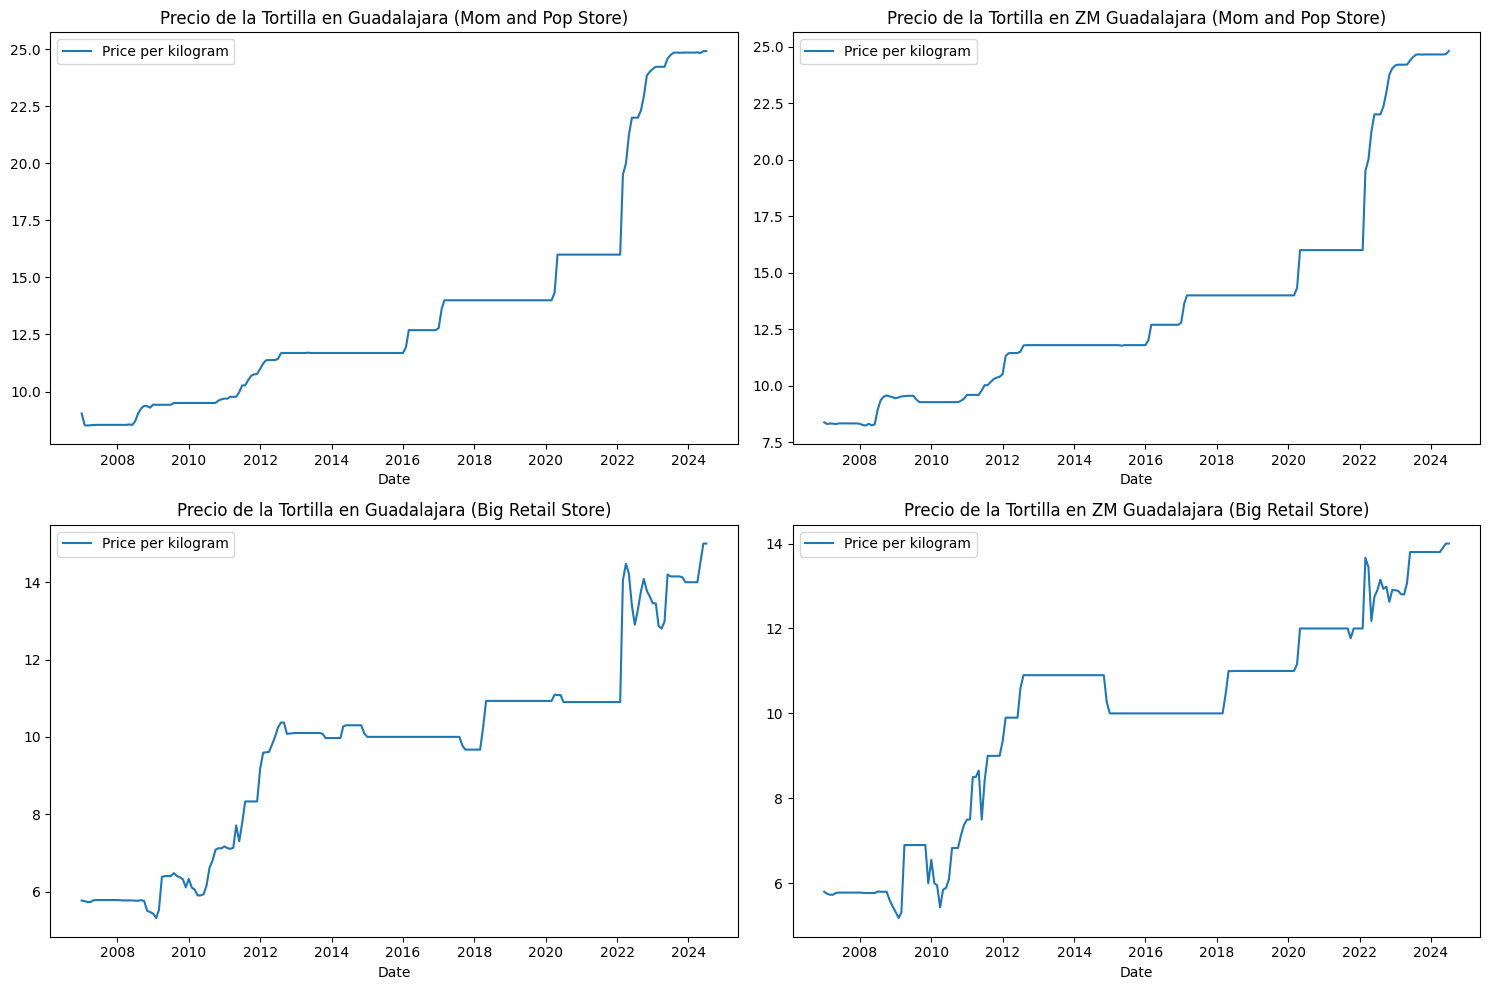

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (df_name, df_filtered) in enumerate(dfs.items()):
    ax = axes[i // 2, i % 2]

    sns.lineplot(data=df_filtered, ax=ax)
    city, store_type = df_name.split('_')[0], df_name.split('_')[1:]
    ax.set_title(f"Precio de la Tortilla en {city} ({' '.join(store_type)})")

plt.tight_layout()
plt.show()

Lo que podemos ver de manera grafica es como de manera general nuestros datos principales (1,1) una tendecia a subir asi como varios periodos de estancamiento en el precio ademas de una importante subida de precio en el 2022 la cual abria que investigar para saber que es lo que causa esta subida 

<Axes: >

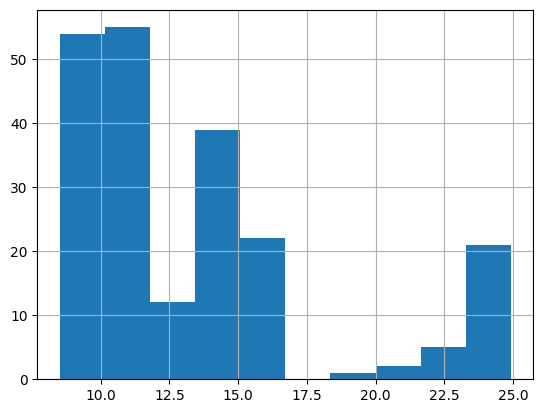

In [120]:
df.hist()

<Axes: ylabel='Density'>

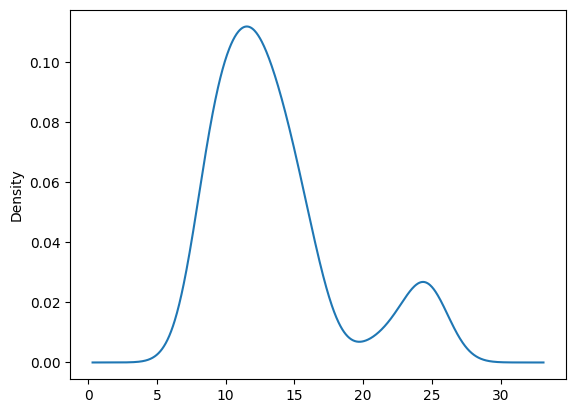

In [121]:
df.plot.density()

In [124]:
piv_index = getattr(df_filtered.index, 'year')
piv_seson = getattr(df_filtered.index, 'month')
piv = pd.pivot_table(df_filtered, index=piv_index, columns=piv_seson, values='Price per kilogram')

([], [])

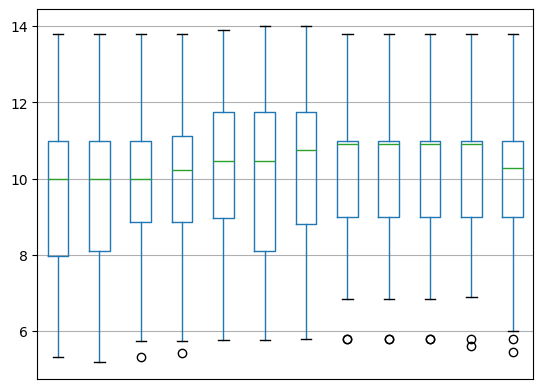

In [125]:
piv.boxplot()
plt.xticks([])

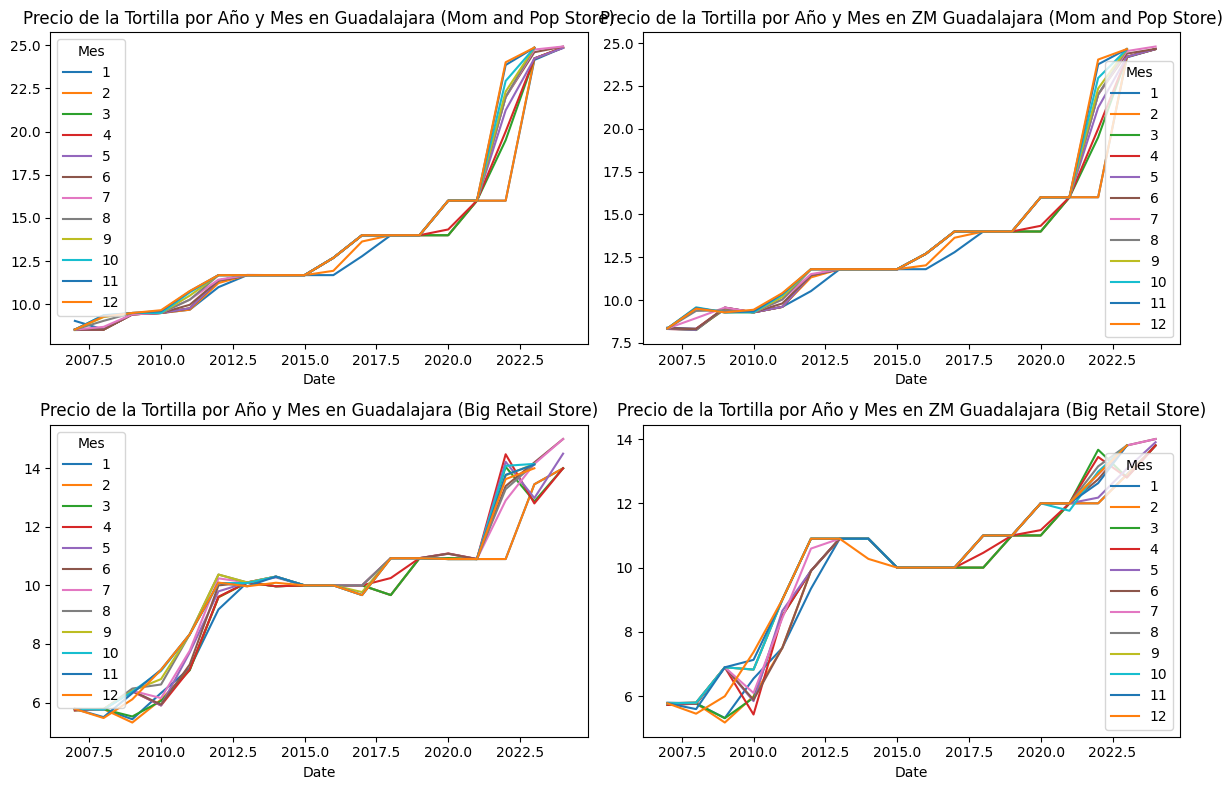

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (df_name, df_filtered) in enumerate(dfs.items()):
    ax = axes[i // 2, i % 2]
    
    
    piv_index = getattr(df_filtered.index, 'year')
    piv_seson = getattr(df_filtered.index, 'month')
    piv = pd.pivot_table(df_filtered, index=piv_index, columns=piv_seson, values='Price per kilogram')
    piv.plot(ax=ax, figsize=(12, 8))
    
    ax.legend(pd.unique(piv_seson), title="Mes")
    city, store_type = df_name.split('_')[0], df_name.split('_')[1:]
    ax.set_title(f"Precio de la Tortilla por Año y Mes en {city} ({' '.join(store_type)})")

plt.tight_layout()
plt.show()

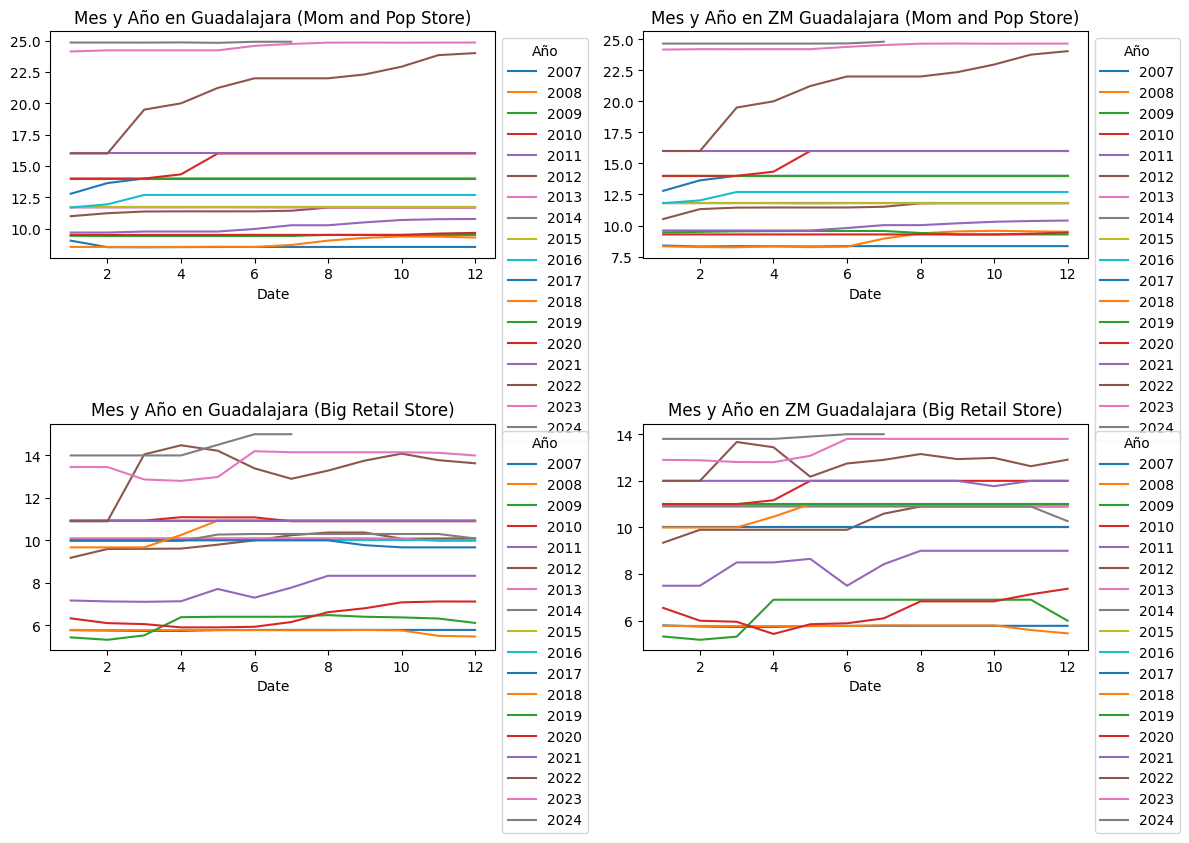

In [113]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (df_name, df_filtered) in enumerate(dfs.items()):
    ax = axes[i // 2, i % 2]
    
    piv_index = getattr(df_filtered.index, 'year')
    piv_seson = getattr(df_filtered.index, 'month')
    piv = pd.pivot_table(df_filtered, index=piv_seson, columns=piv_index, values='Price per kilogram')
    piv.plot(ax=ax, figsize=(12, 8))
    
    ax.legend(pd.unique(piv_index), title="Año", loc='upper left', bbox_to_anchor=(1, 1))
    city, store_type = df_name.split('_')[0], df_name.split('_')[1:]
    ax.set_title(f"Mes y Año en {city} ({' '.join(store_type)})")

plt.tight_layout()
plt.show()

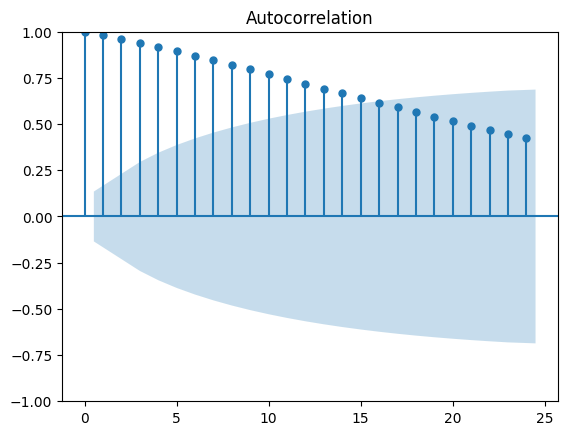

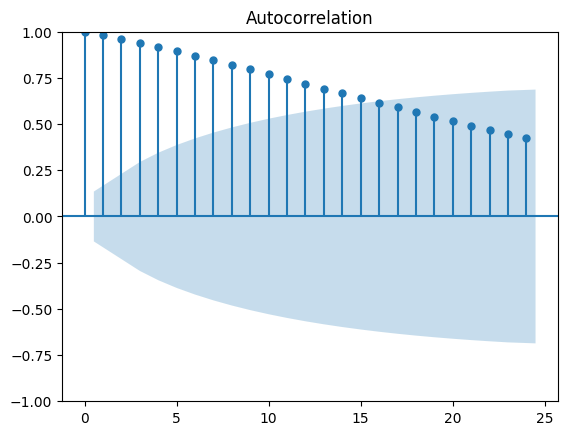

In [114]:
plot_acf(df, lags= 24)

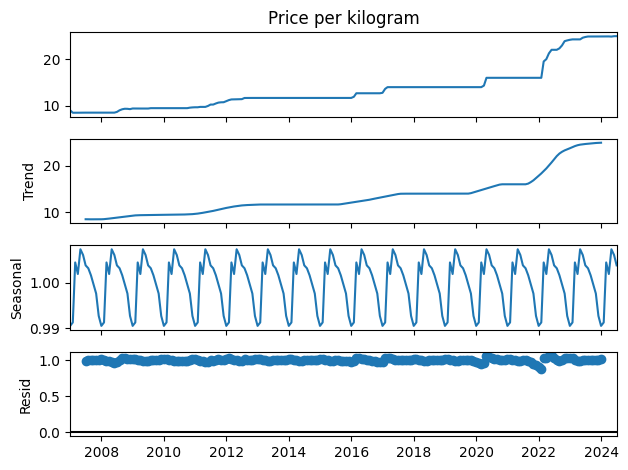

In [115]:
result = seasonal_decompose(df, model='multiplicative')
result.plot()
pyplot.show()

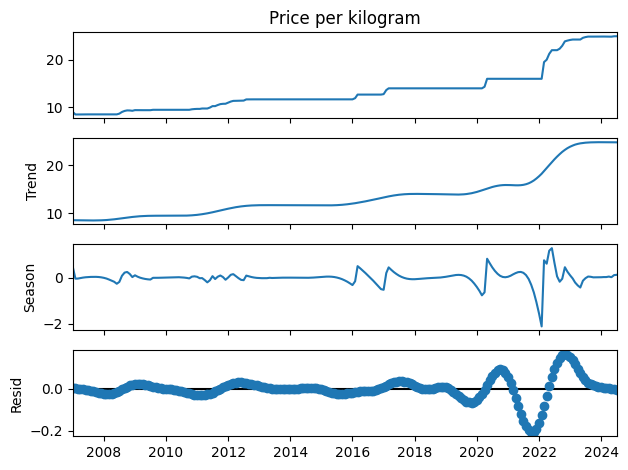

In [116]:
stl = STL(df, seasonal=3, trend = 13)
res = stl.fit()
fig = res.plot()

Vemos como no existe una estacionalidad como tal, cosa la cual era esperado depues de ver la serie de tiempo original, lo que si podemos ver es como los errores se ajustan mejor con la descompsicion multiplicativa.

In [117]:
df.skew()

1.3162658745066194

In [118]:
df.kurtosis()

0.8764373192038315